In [1]:
pip install yfinance numpy pandas scikit-learn matplotlib tensorflow

[*********************100%%**********************]  1 of 1 completed

Epoch 1/10



C:\Users\DARPAN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0527
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0046
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0038
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0032
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0035
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


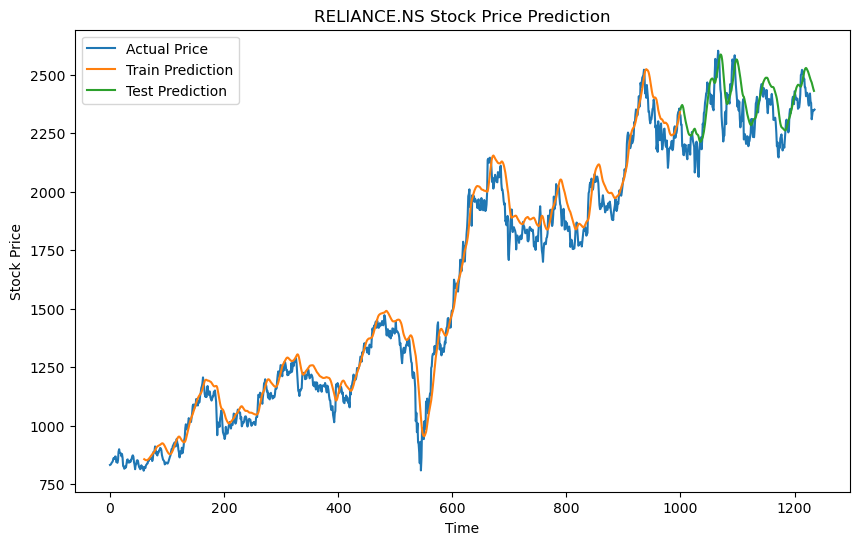

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Fetch stock data
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Load data for a specific stock
ticker = 'RELIANCE.NS'
df = load_data(ticker, '2018-01-01', '2023-01-01')

# Step 2: Preprocess data
# We will predict the 'Close' price
df_close = df['Close']

# Scale data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(df_close).reshape(-1,1))

# Step 3: Create a data structure with 60 timesteps and 1 output
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape input to [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 4: Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 5: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 7: Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Step 8: Adjust prediction plotting

# Shift train predictions for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan

# Calculate the correct start index for the test predictions
test_start_index = len(train_predict) + (time_step)
test_end_index = test_start_index + len(test_predict)

# Ensure the shapes match before assigning the predictions
if test_end_index <= len(test_plot):
    test_plot[test_start_index:test_end_index, :] = test_predict
else:
    raise ValueError(f"Test prediction index {test_end_index} exceeds plot array length {len(test_plot)}")

# Step 9: Plot actual vs. predicted stock prices
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
